# Exploratory Data Analysis
## Author: Grace Pham, Heidi Tran, Jessica Jha, Khanh Tran

In order to downsize the data, a local cluster of sample code from the IBM notebook was run on Apache Spark, an open-source cloud clustering platform. A smaller subset of data was able to be extracted so that all of our group members were able to have access to the same data to split pre-processing tasks. 
 


### Data Dictionary


| Field Name | Type | Description |
| --- | --- | --- |
| Year | int64 | year of the flight |
| Month | int64 | month of the flight  |
| DayofMonth | int64 | day of the month  |
| FlightDate | datetime64[ns] | date of the flight |
| Reporting_Airline | object | unique airline carrier code|
| DOT_ID_Reporting_Airline | int64 | Number assigned by US DOT to identify a unique airline |
| IATA_CODE_Reporting_Airline | object | Airline Code assigned by IATA |
| Tail_Number | object | Aircraft tail number |
| Flight_Number_Reporting_Airline | int64 | Flight Number |
| OriginAirportID | int64 | Origin Airport ID |
| OriginAirportSeqID | int64 | Origin Airport Sequence ID |
| OriginCityMarketID | int64 | Origin City Market ID |
| Origin | object | Origin Airport Code|
| OriginCityName | object | Origin City Name |
| OriginState | object | Origin State | 
| OriginStateFips | int64 | Origin State FIPS place code | 
| DestAirportID | int64 | Destination Airport ID |
| DestAirportSeqID | int64 | Destination Airport Sequence ID |
| OriginWac | int64 | Origin Airport World Area Code |
| DestCityMarketID | int64 | Destination City Market ID |
| Dest | object | Destination Airport Code |
| DestCityName | object | Destination City Name | 
| DestState | object | Destination State | 
| DestStateFips | int64 | Destination State FIPS code |
| DestStateName | object | Destination State Name |
| DestWac | int64 | Destination Airport World Area Code |
| CRSDepTime | int64 | Computer Reservation System (scheduled) Departure Time |
| DepTime | float64 | Departure Time (hhmm) |
| DepDelay | float64 | Departure delay (minutes) |
| DepDelayMinutes | float64 | Absolute value of DepDelay |
| DepartureDelayGroups | float64 | Departure delay 15 minute interval group |
| DepTimeBlk | object | Computer Reservation System (scheduled) time block |
| TaxiOut | float64 | Taxi out time (minutes) |
| WheelsOff | float64 | Wheels off time (local time, hhmm) |
| WheelsOn | float64 | Wheels on time (local time hhmm) |
| TaxiIn | float64 | Taxi in time (minutes) |
| CRSArrTime | int64 | Computer Reservation System (scheduled)
Arrival Time |
| ArrTime | float64 | Arrival time (local time, hhmm) |
| ArrDelay | float64 | Arrival delay (minutes) |
| ArrDelayMinutes | float64 | Absolute value of ArrDelay |
| ArrDel15 | float64 | Arrival Delay >15? |
| ArrivalDelayGroups | float64 | Arrival delay 15 minute  interval group |
| ArrTimeBlk | object | Computer Reservation System (scheduled) arrival time block |
| Cancelled | float64 | 1 = canceled |
| Diverted | float64 | 1 = diverted |
| CRSElapsedTime | float64 | Computer Reservation System (scheduled) elapsed time |
| ActualElapsedTime | float64 | Actual elapsed time |
| AirTime | float64 | Flight time (minutes) |
| Distance | float64 | Distance between airports (miles) |
| DistanceGroup | int64 | 250 mile distance interval group |
| CarrierDelay | float64 | Carrier delay (minutes) |
| WeatherDelay | float64 | Weather delay (minutes) |
| NASDelay | float64 | National Air System delay (minutes) |
| SecurityDelay | float64 | Security delay (minutes) |
| LateAircraftDelay | float64 | Late aircraft delay (minutes) |
| DivAirportLandings | int64 | Number of diverted airport landings |                     

### Import packages

In [1]:
import sys
import json
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
#from google.colab import data_table
# import <put_your_packages_here>

# Config seaborn
sns.set(rc={"figure.figsize":(12, 10)})
sns.set_style("whitegrid")

### Common utilities that we can re-use.

these functions were given to us by IBM sample notebook

In [2]:
from re import I
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
        I doubt that we would use up what Colab gives us in the free tier, but still it's a helpful util.
    :param df: pandas DataFrame    
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file: str, json=False) -> pd.DataFrame:
    """Create a dataframe and optimize its memory usage
    :param file: filepath.
    """
    if json:
        try:
            df = pd.read_json(file)
            df = reduce_mem_usage(df)
        except ValueError:
            df = pd.read_json(file, lines=True)
            df = reduce_mem_usage(df)
    elif not json:
        df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
        df = reduce_mem_usage(df)
    return df


# TODO: Feel free to write the function.
def get_data_from_api():
    """
    """
    pass

    
def index_file_checker(df, col_name):
    """
    """
    return df[df[col_name].isnull()].index.tolist()


def check_field(df, col_name):
    """
    """
    ind_miss = index_file_checker(df=df, col_name=col_name)
    
    if ind_miss == []:
        print("No Null values of {x}".format(x = col_name))
        if len(df) == len(df[col_name].unique()):
            print("All records of {x} is populated for the \"M Field\" and are unique".format(x = col_name))
            
    else:
        pctMissing = 100*(len(ind_miss)/len(df))
        print(f"Percentage of missing {col_name} field: {pctMissing:.2f}%")


def check_duplicate_values(df: pd.DataFrame, col_name: str =None):
    '''Check for duplicate values in a given column in a given dataframe. If no column is given, only check for duplicate rows in the dataframe.
    '''
    try:
        if col_name is not None:
            dups = df.duplicated(subset=[col_name], keep='first')
            len_dups = len(dups[dups==True])
            percent_dups = 100*len_dups/len(df)

            if len_dups == 0:
                print(f"\nNo duplicate values in {col_name} field.")
            elif len_dups > 0:
                print(f"\nPercentage of duplicate values in {col_name} field: {percent_dups}")
                print(f"Percentage of unique values in {col_name} field: {100-percent_dups}")
        elif col_name is None:
            dups = df.duplicated(keep='first')
            len_dups = len(dups[dups==True])
            percent_dups = 100*len_dups/len(df)
            
            if len_dups == 0:
                print(f"\nNo duplicate rows in dataframe.")
            elif len_dups > 0:
                print(f"\nPercentage of duplicate rows in dataframe: {percent_dups}")
                print(f"\nPercentage of unique rows in dataframe: {100-percent_dups}")
    except Exception as e:
        print(e)


def calculate_bound_values(df, col_name):
  ''' Calculate lower and upper bound value for given column in the dataframe
  '''
  Q1 = df[col_name].quantile(0.25)
  Q3 = df[col_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (lower_bound, upper_bound)


def check_outliers(df: pd.DataFrame, col_name: str = None):
  '''Print out information about the lower boundary, upper boundary and percentage of outliers
  '''
  lower_bound, upper_bound = calculate_bound_values(df, col_name)
  
  outliers_lower = df[col_name][df[col_name] < lower_bound]
  outliers_upper = df[col_name][df[col_name] > upper_bound]
  outliers_cnt = len(outliers_lower) + len(outliers_upper)
  outliers_pct = (outliers_cnt * 100) / len(df[col_name])
  print(f"Column: {col_name}. Lower boundary: {lower_bound}. Upper boundary: {upper_bound}. Percentage of outliers: {outliers_pct:.2f}%")


def remove_outliers(df, col_name):
  '''Replace outliers at given column with null values
  '''
  lower_bound, upper_bound = calculate_bound_values(df, col_name)
  df[col_name] = df[col_name][(df[col_name] < upper_bound) & (df[col_name] > lower_bound)]
  

def get_numeric_cols(df: pd.DataFrame):
  '''Return the names of all the numeric columns in a Data Frame
  '''
  return list(df.select_dtypes(include=[np.number]).columns.values)


def drop_col(df: pd.DataFrame, col_name: str = None) -> pd.DataFrame:
  '''Drop a column in a Data Frame and return the new Data Frame
  '''
  return df.drop(col_name, axis='columns')


def drop_cols_with_missing_val_threshold(df, threshold): 
  '''Drop columns which has percentage of missing value surpassed the input threshold
  Return a new dataframe in which unqualified columns has been dropped
  '''
  threshold_percentage = len(df) * threshold
  return df.dropna(thresh=threshold_percentage, axis=1)


def display_bar_char(xName: str, yName: str, df: pd.DataFrame, orient: str, figSize: (int, int), title: str):
    fig = plt.figure(figsize=figSize)
    ax = plt.axes()
    sns.barplot(x = xName, y = yName, data = df, orient = orient, ax = ax).set(title = title)

In [6]:
airline_df = pd.read_csv("./data/airlines_updated.csv")
airportMapping = pd.read_csv("./data/AirlineCodeMapping.csv")

## Review preprocessing Steps:

### First 5 rows

In [ ]:
airline_df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum
0,2019,2,6,11,2,2019-06-11,9E,20363,9E,N927XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,1,2,8,4,2018-02-08,WN,19393,WN,N8688J,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,2,4,3,4,2014-04-03,WN,19393,WN,N374SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,3,9,5,6,2015-09-05,AS,19930,AS,N589AS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,3,7,26,3,2017-07-26,WN,19393,WN,N252WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Columns

In [ ]:
list(airline_df.columns)

['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'FlightDate',
 'Reporting_Airline',
 'DOT_ID_Reporting_Airline',
 'IATA_CODE_Reporting_Airline',
 'Tail_Number',
 'Flight_Number_Reporting_Airline',
 'OriginAirportID',
 'OriginAirportSeqID',
 'OriginCityMarketID',
 'Origin',
 'OriginCityName',
 'OriginState',
 'OriginStateFips',
 'OriginStateName',
 'OriginWac',
 'DestAirportID',
 'DestAirportSeqID',
 'DestCityMarketID',
 'Dest',
 'DestCityName',
 'DestState',
 'DestStateFips',
 'DestStateName',
 'DestWac',
 'CRSDepTime',
 'DepTime',
 'DepDelay',
 'DepDelayMinutes',
 'DepDel15',
 'DepartureDelayGroups',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOff',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrTime',
 'ArrDelay',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrivalDelayGroups',
 'ArrTimeBlk',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'AirTime',
 'Flights',
 'Distance',
 'DistanceGroup',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityD

### Drop `Flights` column
	
The `Flights` column indicates the number of flights, which is usually only "1" in the dataset, so this column would not be beneficial for our analysis.

In [ ]:
airline_df = drop_col(airline_df, "Flights")

### Drop `Quarter` and `DayOfWeek` column
We don't plan to use these two columns for analysis. Furthermore, the `FlightDate` column already gives us enough information to recalculate quarter and day of week if necessary.

In [ ]:
airline_df = drop_col(airline_df, "Quarter")
airline_df = drop_col(airline_df, "DayOfWeek")

### Drop   `OriginStateName` column 
There is already an `OriginState` column which has the state abbreviations which we can use for our analysis. Therefore, dropping this column would help condense our values and have our dataset be less redundant.

In [ ]:
airline_df = airline_df.drop(columns=['OriginStateName'], axis=1)

### Drop column `DepDel15`
The `DepDel15` column indicates that the delay for departure was greater than 15 minutes as a boolean (1 for delay greater than 15 minutes, 0 for delays less than 15 minutes). We are keeping other columns which have actual minute values (such as `DepDelay` and `DepDelayMinutes` so we do not need another indicator of departure delays.

In [ ]:
airline_df = drop_col(airline_df, "DepDel15")

### Drop column `ArrDel15`
The `ArrDel15` column indicates that the arrival time delay was greater than 15 minutes as a boolean (1 for delay greater than 15 minutes, 0 for delays less than 15 minutes). We are keeping other columns which have actual minute values (such as `ArrDelay` and `ArrDelayMinutes` so we do not need another indicator of arrival delays.

In [ ]:
airline_df = drop_col(airline_df, "ArrDel15")

### Drop columns  `DepartureDelayGroups` and `ArrivalDelayGroups`
Both  `DepartureDelayGroups` and `ArrivalDelayGroups`indicate delay 15 minute interval groups - this column is filled with integers from -1 and NaNs and regular postive integers, but it will not be beneficial to our analysis as interval groups are not clear indicators as to how long the plane was delayed.

In [ ]:
airline_df = drop_col(airline_df, "DepartureDelayGroups")
airline_df = drop_col(airline_df, "ArrivalDelayGroups")

### Drop column `DivAirportLandings`
There a little under 1,000 diverted airport landings in a dataset of 300,000+ records (only .3%), so drawing conclusions off delays based of this type of data would be statisically insignificant and not add value to our analysis and predictions.

In [ ]:
sum(airline_df.DivAirportLandings > 0)

967

In [ ]:
airline_df = drop_col(airline_df, "DivAirportLandings")

### Drop column `DistanceGroup`
`DistanceGroup` is defined as "250 mile distance interval group" - we will not be using pre-set groups in our analysis and predictions so we can drop this column to reduce redundant data. In addition, have the `Distance` column which provides more precise flight distance. 

In [ ]:
airline_df.DistanceGroup

0          1
1          4
2          3
3          3
4          2
          ..
386420     1
386421    10
386422     8
386423     2
386424     4
Name: DistanceGroup, Length: 386425, dtype: int64

In [ ]:
airline_df = drop_col(airline_df, "DistanceGroup")

### Columns' data types

In [ ]:
airline_df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
FlightDate            object
Reporting_Airline     object
                      ...   
Div5WheelsOn         float64
Div5TotalGTime       float64
Div5LongestGTime     float64
Div5WheelsOff        float64
Div5TailNum          float64
Length: 99, dtype: object

&rightarrow; We can see that a lot of columns have wrong data types. For example, `FlightDate` should have type `datetime` instead of `object`. We need to fix these columns' types later.

### Fix data type for `datetime` column

In [ ]:
#convert to datetime
airline_df['FlightDate'] = pd.to_datetime(airline_df['FlightDate'], format='%Y-%m-%d')

In [ ]:
airline_df.dtypes

Year                          int64
Month                         int64
DayofMonth                    int64
FlightDate           datetime64[ns]
Reporting_Airline            object
                          ...      
Div5WheelsOn                float64
Div5TotalGTime              float64
Div5LongestGTime            float64
Div5WheelsOff               float64
Div5TailNum                 float64
Length: 99, dtype: object

### Remove cancelled flights
We don't need cancelled flights because that indicates a flight that was delayed "forever" so we need to remove it from our data.

In [ ]:
airline_df = airline_df[airline_df["Cancelled"] == 0]

In [ ]:
# We don't need this column anymore since it contains all 1s
airline_df = drop_col(airline_df, "Cancelled")

### Add a new column `IsDepDelay` denotes whether a flight delayed departure

In [ ]:
airline_df['IsDepDelay'] = airline_df["DepDelayMinutes"] > 0

### Add a new column `IsArrDelay` denotes whether a flight delayed departure

In [ ]:
airline_df['IsArrDelay'] = airline_df["ArrDelayMinutes"] > 0

### Check missing values

In [ ]:
for col in airline_df.columns:
    check_field(airline_df, col)

No Null values of Year
No Null values of Month
No Null values of DayofMonth
No Null values of FlightDate
No Null values of Reporting_Airline
No Null values of DOT_ID_Reporting_Airline
No Null values of IATA_CODE_Reporting_Airline
No Null values of Tail_Number
No Null values of Flight_Number_Reporting_Airline
No Null values of OriginAirportID
No Null values of OriginAirportSeqID
No Null values of OriginCityMarketID
No Null values of Origin
No Null values of OriginCityName
No Null values of OriginState
No Null values of OriginStateFips
No Null values of OriginWac
No Null values of DestAirportID
No Null values of DestAirportSeqID
No Null values of DestCityMarketID
No Null values of Dest
No Null values of DestCityName
No Null values of DestState
No Null values of DestStateFips
No Null values of DestStateName
No Null values of DestWac
No Null values of CRSDepTime
No Null values of DepTime
Percentage of missing DepDelay field: 0.02%
Percentage of missing DepDelayMinutes field: 0.02%
No Null 

&rightarrow; Some columns have less than 5% missing values. However, some columns have > 95% of missing values. We will drop columns with more than 95% of missing values.

### Drop columns with more than 95% of missing values

In [ ]:
# Check the size of airline_df BEFORE dropping columns
airline_df.shape

(379965, 100)

In [ ]:
airline_df = drop_cols_with_missing_val_threshold(airline_df, 0.95)

In [ ]:
# Check the size of airline_df AFTER dropping columns
airline_df.shape

(379965, 47)

In [ ]:
airline_df.head()

,Year,Month,DayofMonth,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,...,ArrDelay,ArrDelayMinutes,ArrTimeBlk,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,IsDepDelay,IsArrDelay
0,2019,6,11,2019-06-11,9E,20363,9E,N927XJ,3459,10397,...,214.0,214.0,2000-2059,0.0,67.0,60.0,35.0,192.0,True,True
1,2018,2,8,2018-02-08,WN,19393,WN,N8688J,5932,13232,...,29.0,29.0,2200-2259,0.0,140.0,153.0,114.0,793.0,True,True
2,2014,4,3,2014-04-03,WN,19393,WN,N374SW,1463,11540,...,-5.0,0.0,1300-1359,0.0,95.0,90.0,77.0,562.0,False,False
3,2015,9,5,2015-09-05,AS,19930,AS,N589AS,413,14869,...,-23.0,0.0,1800-1859,0.0,130.0,119.0,102.0,689.0,False,False
5,2019,9,2,2019-09-02,YX,20452,YX,N203JQ,6104,12451,...,-3.0,0.0,1400-1459,0.0,168.0,169.0,149.0,1010.0,False,False


### Check duplicated rows

In [ ]:
check_duplicate_values(df=airline_df)


No duplicate rows in dataframe.


### Rename columns' name for ease of analysis

In [ ]:
airline_df.columns

Index(['Year', 'Month', 'DayofMonth', 'FlightDate', 'Reporting_Airline',
       'DOT_ID_Reporting_Airline', 'IATA_CODE_Reporting_Airline',
       'Tail_Number', 'Flight_Number_Reporting_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginWac', 'DestAirportID',
       'DestAirportSeqID', 'DestCityMarketID', 'Dest', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'CRSDepTime',
       'DepTime', 'DepDelay', 'DepDelayMinutes', 'DepTimeBlk', 'TaxiOut',
       'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay',
       'ArrDelayMinutes', 'ArrTimeBlk', 'Diverted', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'Distance', 'IsDepDelay', 'IsArrDelay'],
      dtype='object')

In [ ]:
airline_df.rename(columns={"Reporting_Airline":"Airline",
                   "Origin":"Origin_Airport",
                  "Dest":"Dest_Airport",
                  "CRSDepTime":"Scheduled_Departure",
                  "DepTime":"Departure_Time",
                  "DepDelay":"Departure_Delay",
                  "CRSArrTime":"Scheduled_Arrival",
                  "ArrTime":"Arrival_Time",
                  "ArrDelay":"Arrival_Delay",
                  "CRSElapsedTime":"Scheduled_Time",
                  "ActualElapsedTime":"Elapsed_Time",
                  "DOT_ID_Reporting_Airline":"DOT_ID_Airline",
                  "IATA_CODE_Reporting_Airline":"IATA_CODE_Airline",
                  "Flight_Number_Reporting_Airline":"Flight_Number_Airline",
                  "DayofMonth":"Day"} ,inplace=True)

In [ ]:
# Check new columns
airline_df.columns

Index(['Year', 'Month', 'Day', 'FlightDate', 'Airline', 'DOT_ID_Airline',
       'IATA_CODE_Airline', 'Tail_Number', 'Flight_Number_Airline',
       'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID',
       'Origin_Airport', 'OriginCityName', 'OriginState', 'OriginStateFips',
       'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID',
       'Dest_Airport', 'DestCityName', 'DestState', 'DestStateFips',
       'DestStateName', 'DestWac', 'Scheduled_Departure', 'Departure_Time',
       'Departure_Delay', 'DepDelayMinutes', 'DepTimeBlk', 'TaxiOut',
       'WheelsOff', 'WheelsOn', 'TaxiIn', 'Scheduled_Arrival', 'Arrival_Time',
       'Arrival_Delay', 'ArrDelayMinutes', 'ArrTimeBlk', 'Diverted',
       'Scheduled_Time', 'Elapsed_Time', 'AirTime', 'Distance', 'IsDepDelay',
       'IsArrDelay'],
      dtype='object')

### Check outliers

In [ ]:
# Select only numeric cols that is not date time cols
outliers_cols = ['Scheduled_Departure',
       'Departure_Time', 'Departure_Delay', 'DepDelayMinutes', 
       'TaxiOut', 'WheelsOff',
       'WheelsOn', 'TaxiIn', 'Scheduled_Arrival', 'Arrival_Time', 'Arrival_Delay',
       'ArrDelayMinutes', 'Scheduled_Time', 'Elapsed_Time',
       'AirTime', 'Distance']
for col in outliers_cols:
  check_outliers(airline_df, col)

Column: Scheduled_Departure. Lower boundary: -310.5. Upper boundary: 2957.5. Percentage of outliers: 0.00%
Column: Departure_Time. Lower boundary: -320.5. Upper boundary: 2979.5. Percentage of outliers: 0.00%
Column: Departure_Delay. Lower boundary: -23.0. Upper boundary: 25.0. Percentage of outliers: 13.28%
Column: DepDelayMinutes. Lower boundary: -10.5. Upper boundary: 17.5. Percentage of outliers: 16.88%
Column: TaxiOut. Lower boundary: -1.0. Upper boundary: 31.0. Percentage of outliers: 5.95%
Column: WheelsOff. Lower boundary: -305.5. Upper boundary: 2994.5. Percentage of outliers: 0.00%
Column: WheelsOn. Lower boundary: -244.5. Upper boundary: 3207.5. Percentage of outliers: 0.00%
Column: TaxiIn. Lower boundary: -3.5. Upper boundary: 16.5. Percentage of outliers: 5.41%
Column: Scheduled_Arrival. Lower boundary: -116.0. Upper boundary: 3140.0. Percentage of outliers: 0.00%
Column: Arrival_Time. Lower boundary: -244.5. Upper boundary: 3215.5. Percentage of outliers: 0.00%
Column: Ar

<AxesSubplot:>

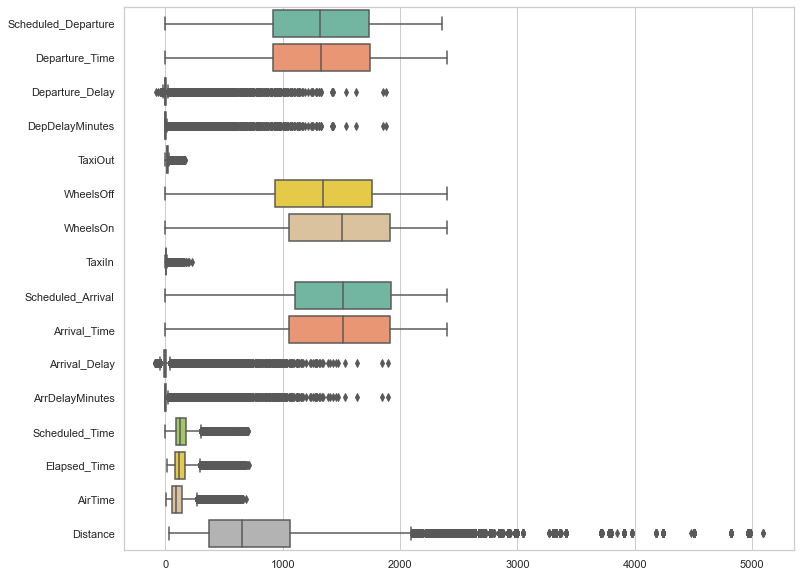

In [ ]:
# Visualize outliers with box plots
sns.boxplot(data=airline_df[outliers_cols], orient="h", palette="Set2")

&rightarrow; `DepDelay`, `DepDelayMinutes`, `ArrDelay`, `ArrDelayMinutes` have about 10% outliers. We will need to remove extreme outliers.

### Remove extreme outliers

In [ ]:
# Removing the outliers from the columns with extreme outlier values
extreme_outlier_cols = ["Departure_Delay", "DepDelayMinutes", "Arrival_Delay", "ArrDelayMinutes"]
for col in extreme_outlier_cols:
  remove_outliers(airline_df, col)

In [ ]:
# Re-checking the dataframe after removing extreme outliers
for col in extreme_outlier_cols:
  check_outliers(airline_df, col)

Column: Departure_Delay. Lower boundary: -16.5. Upper boundary: 11.5. Percentage of outliers: 7.52%
Column: DepDelayMinutes. Lower boundary: 0.0. Upper boundary: 0.0. Percentage of outliers: 19.16%
Column: Arrival_Delay. Lower boundary: -42.0. Upper boundary: 30.0. Percentage of outliers: 2.65%
Column: ArrDelayMinutes. Lower boundary: 0.0. Upper boundary: 0.0. Percentage of outliers: 20.16%


### Map airline codes to their names 

In [ ]:
airline_df['Airline']

0         9E
1         WN
2         WN
3         AS
4         YX
          ..
379960    AA
379961    UA
379962    DL
379963    B6
379964    DL
Name: Airline, Length: 379965, dtype: object

In [ ]:
airportMapping.head()

,Code,Airline
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


In [ ]:
airportMapping.rename(columns={"Airline":"Airline_Name"}, inplace=True)
airportMapping.head()

,Code,Airline_Name
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


In [ ]:
airline_df = airline_df.merge(airportMapping, left_on='Airline', right_on='Code')

In [ ]:
# Check
airline_df[['Airline', 'Airline_Name']]

,Airline,Airline_Name
0,9E,Endeavor Air Inc.
1,9E,Endeavor Air Inc.
2,9E,Endeavor Air Inc.
3,9E,Endeavor Air Inc.
4,9E,Endeavor Air Inc.
...,...,...
379960,FL,AirTran Airways Corporation
379961,FL,AirTran Airways Corporation
379962,FL,AirTran Airways Corporation
379963,FL,AirTran Airways Corporation


# Exploratory Data Analysis:

### 1. Summary Statistics
We'll run summary statistics for selected numeric fields which support our further analysis:

In [7]:
airline_df.filter(items=['Departure_Delay', 'DepDelayMinutes', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'Arrival_Delay', 'ArrDelayMinutes', 'Elapsed_Time', 'AirTime', 'Distance']).describe(include=[np.number])

,Departure_Delay,DepDelayMinutes,TaxiOut,WheelsOff,WheelsOn,TaxiIn,Arrival_Delay,ArrDelayMinutes,Elapsed_Time,AirTime,Distance
count,329427.000000,315765.000000,379965.000000,379965.000000,379829.000000,379829.000000,344650.000000,319996.000000,379043.000000,379043.000000,379965.000000
mean,-0.998176,1.596494,16.658626,1356.866256,1467.538413,7.516888,-4.743612,2.022925,137.651306,113.488939,822.275123
std,7.609791,3.713673,9.395468,502.575606,528.702138,5.878215,14.995160,4.477969,74.159384,72.084647,607.192756
min,-23.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-47.000000,0.000000,15.000000,8.000000,31.000000
25%,-6.000000,0.000000,11.000000,932.000000,1050.000000,4.000000,-15.000000,0.000000,83.000000,60.000000,372.000000
50%,-3.000000,0.000000,14.000000,1341.000000,1506.000000,6.000000,-7.000000,0.000000,119.000000,94.000000,650.000000
75%,1.000000,0.000000,19.000000,1757.000000,1913.000000,9.000000,3.000000,0.000000,169.000000,144.000000,1062.000000
max,25.000000,17.000000,169.000000,2400.000000,2400.000000,224.000000,41.000000,20.000000,713.000000,684.000000,5096.000000


### 2. How often are flights delayed on departure?

In [8]:
# Calculate the total count of departure flights from all airports
total_dep_flights = airline_df['Flight_Number_Airline'].count()
# Calculate the total count of 'Delayed' departure flights from all airports
total_delayed_dep_flights = airline_df['Flight_Number_Airline'].loc[airline_df['IsDepDelay'] == 1].count()

In [9]:
# Percentage of flights being delayed on departure
p_delayed_dep = round((total_delayed_dep_flights/total_dep_flights)*100, 2)
p_delayed_dep

36.04

### 3. How often are flights delayed on arrival?

In [10]:
# Calculate the total count of arrival flights from all airports
total_arr_flights = airline_df['Flight_Number_Airline'].count()
# Calculate the total count of 'Delayed' arrival flights from all airports
total_delayed_arr_flights = airline_df['Flight_Number_Airline'].loc[airline_df['IsArrDelay'] == 1].count()

In [11]:
# Percentage of flights being delayed on arrival
p_delayed_arr = round((total_delayed_arr_flights/total_arr_flights)*100, 2)
p_delayed_arr

36.2

We can see that the percentage of flights being delayed on arrival and on departure are roughly similar, both are having around over 36% of delayed flights.

### 4. Airports with most number of flights
#### Flights from departure airports:

In [12]:
number_of_flight_dep = airline_df.groupby('Origin_Airport')['Flight_Number_Airline'].count().reset_index(name = 'Total Flights')
top10_number_of_flight_dep = number_of_flight_dep.sort_values('Total Flights',ascending = False).head(10)
top10_number_of_flight_dep

,Origin_Airport,Total Flights
21,ATL,23319
257,ORD,17626
97,DFW,15064
96,DEN,13905
196,LAX,13131
319,SFO,10333
272,PHX,10062
170,IAH,9698
76,CLT,9405
194,LAS,9345


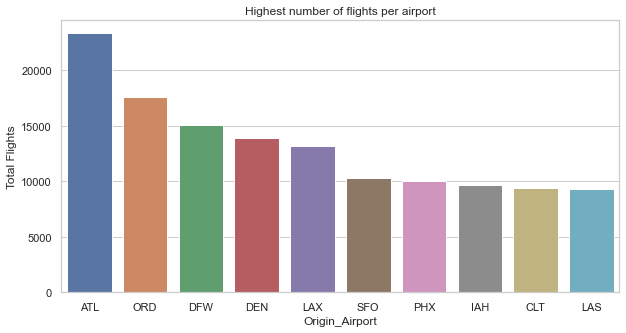

In [13]:
display_bar_char('Origin_Airport', 'Total Flights', top10_number_of_flight_dep, 'v', (10, 5), "Highest number of flights per airport")

- We can see from here that airport ATL is the one with the highest number of departure flights of over 23000 flights recorded.
- Airports SFO, PHX, IAH, CLT, LAS are also the ones which made it to the top 10 of highest number of departure flights, but their total flights are around 10,000 flights only, which is about half of the number of flights from airport ATL

#### Flights from arrival airports:

In [14]:
number_of_flight_arr = airline_df.groupby('Dest_Airport')['Flight_Number_Airline'].count().reset_index(name = 'Total Flights')
top10_number_of_flight_arr = number_of_flight_arr.sort_values('Total Flights',ascending = False).head(10)
top10_number_of_flight_arr

,Dest_Airport,Total Flights
21,ATL,23221
256,ORD,17992
97,DFW,15180
96,DEN,13876
195,LAX,13375
318,SFO,10536
271,PHX,10123
169,IAH,9626
193,LAS,9444
76,CLT,9298


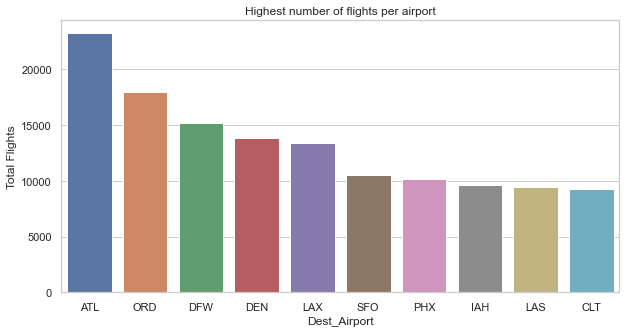

In [15]:
display_bar_char('Dest_Airport', 'Total Flights', top10_number_of_flight_arr, 'v', (10, 5), "Highest number of flights per airport")

- We can see from here that airport ATL is also the one with the highest number of arrival flights of over 23000 flights recorded. It marked the huge differences when comparing to other airports in top 10.
- Airports SFO, PHX, IAH, CLT, LAS are also the ones which made it to the top 10 of highest number of departure flights, but their total flights are around 10,000 flights only, which is about half of the number of flights from airport ATL

### 5. Airports with highest frequency of departure delay

In [16]:
dep_delay_freq = airline_df.groupby('Origin_Airport')['IsDepDelay'].sum().reset_index(name = 'Total Departure Delays')
top10_dep_delay_freq = dep_delay_freq.sort_values('Total Departure Delays',ascending = False).head(10)
top10_dep_delay_freq

,Origin_Airport,Total Departure Delays
21,ATL,8505
257,ORD,6960
96,DEN,5914
97,DFW,5787
196,LAX,5376
194,LAS,4102
319,SFO,4031
272,PHX,3858
76,CLT,3442
170,IAH,3392


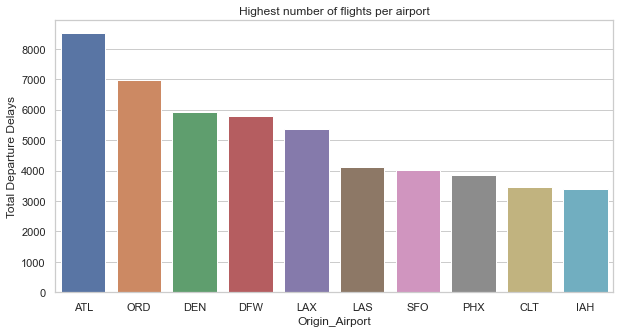

In [17]:
display_bar_char('Origin_Airport', 'Total Departure Delays', top10_dep_delay_freq, 'v', (10, 5), "Highest number of flights per airport")

We can see here that ATL is the airport with highest number of flights being delayed. But does this mean the rate of delay in ATL airport is also high? Let's look at the percentage of delayed flights per airport below:

In [22]:
# Calculate delay percentage for departure flights in top 10 airports with highest delayed flight count
delay_percentages = []
for index, row in top10_dep_delay_freq.iterrows():
    airport = row["Origin_Airport"]
    total_delay = row["Total Departure Delays"]
    total_flight = number_of_flight_dep["Total Flights"].loc[number_of_flight_dep["Origin_Airport"] == airport].values[0]
    # Calculate delay departure percentage for an airport
    delay_percentage = round((total_delay/total_flight)*100, 2)
    # Append calculated percentage to the list
    delay_percentages.append(delay_percentage)
delay_percentages # List of percentage for flight delay in top 10 highest delayed flight airports

[36.47, 39.49, 42.53, 38.42, 40.94, 43.9, 39.01, 38.34, 36.6, 34.98]

In [23]:
# Create a new column in data frame top10_dep_delay_freq
top10_dep_delay_freq["Delay Percentage"] = delay_percentages

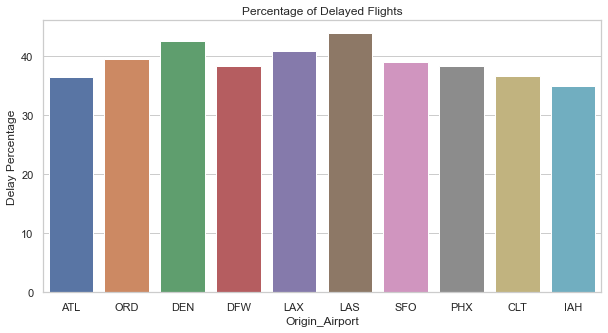

In [24]:
display_bar_char('Origin_Airport', 'Delay Percentage', top10_dep_delay_freq, 'v', (10, 5), "Percentage of Delayed Flights")

- After calculating the percentage, we can see that although ATL is the airport with highest number of delayed flights, its percentage of delayed flights is one of the lowest this top 10 highest delay flight counts.
- On the other hand, LAS airport, which was having only 4,000 delayed flights recorded, actually have the highest rate of delay (approximately 44%)

### 6. Airports with highest frequency of arrival delay

In [26]:
arr_delay_freq = airline_df.groupby('Dest_Airport')['IsArrDelay'].sum().reset_index(name = 'Total Arrival Delays')
top10_arr_delay_freq = arr_delay_freq.sort_values('Total Arrival Delays',ascending = False).head(10)
top10_arr_delay_freq

,Dest_Airport,Total Arrival Delays
21,ATL,6994
256,ORD,6613
97,DFW,5515
195,LAX,5383
96,DEN,4769
318,SFO,4418
271,PHX,3820
193,LAS,3502
169,IAH,3303
76,CLT,3092


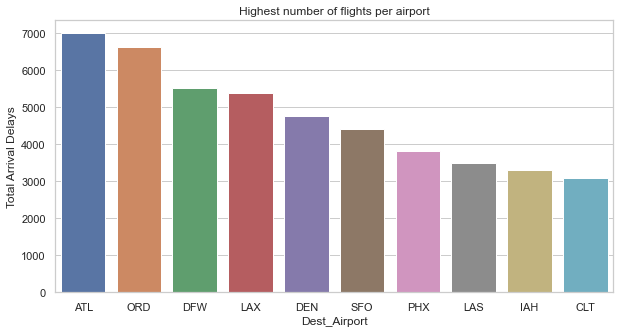

In [27]:
display_bar_char('Dest_Airport', 'Total Arrival Delays', top10_arr_delay_freq, 'v', (10, 5), "Highest number of flights per airport")

- We can see that the top 10 airports with highest counts of delayed arrival flights is the same of top 10 airport with most delayed departure flights
- For either departure or arrival flights, ATL airport is still the one with highest number of flight being delayed. However, the number of delayed arrival flights is around 7,000 flights, which is less than that of departure flights, which is at over 8,00 flights.
- Aiport IAH and CLT are also one of the airports with least number of delayed flight in the top 10 with highest delayed. For arrival flights, they had around 3,000 delayed flight, which is less than half of that in ATL.

Let's look at the percentage of delayed flights per airport to see which airport will have highest delayed arrival flight percentage below:

In [28]:
# Calculate delay percentage for arrival flights in top 10 airports with highest delayed flight count
delay_percentages = []
for index, row in top10_arr_delay_freq.iterrows():
    airport = row["Dest_Airport"]
    total_delay = row["Total Arrival Delays"]
    total_flight = number_of_flight_arr["Total Flights"].loc[number_of_flight_arr["Dest_Airport"] == airport].values[0]
    # Calculate delay arrival percentage for an airport
    delay_percentage = round((total_delay/total_flight)*100, 2)
    # Append calculated percentage to the list
    delay_percentages.append(delay_percentage)
delay_percentages # List of percentage for flight delay in top 10 highest delayed flight airports

[30.12, 36.76, 36.33, 40.25, 34.37, 41.93, 37.74, 37.08, 34.31, 33.25]

In [29]:
# Create a new column in data frame top10_arr_delay_freq
top10_arr_delay_freq["Delay Percentage"] = delay_percentages

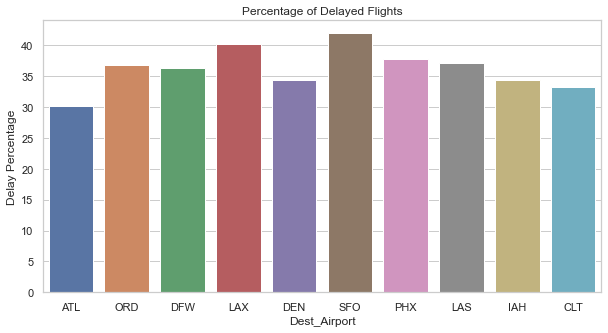

In [30]:
display_bar_char('Dest_Airport', 'Delay Percentage', top10_arr_delay_freq, 'v', (10, 5), "Percentage of Delayed Flights")

- Surprisingly, although ATL is the airport with highest number of delayed flights, its percentage of delayed flights is actually the lowest in this top 10 highest delay flight counts. This may be because ATL is a large airport with a huge number of arrival/departure flights.
- SFO airport, which has the second highest in percentage of departure flight delayed, is the airport with highest arrival flights delayed! The statistics suggest that over 41% of flights to SFO will be delayed.

### 7. Airports with high mean departure delay in minutes? 

In [ ]:
# TODO: Replace 'Origin_Airport' columns with 'Origin_Airport_Name'
airline_df.groupby('Origin_Airport')['DepDelayMinutes'] \
    .mean() \
    .reset_index(name = 'Mean delay (minutes)') \
    .sort_values('Mean delay (minutes)', ascending = False).head()

,Origin_Airport,Mean delay (minutes)
250,OGD,13.0
19,ART,9.0
262,OWB,4.5
40,BKG,4.0
174,ILG,4.0


### 8. Airports with high mean arrival delay in minutes? 

In [ ]:
# TODO: Replace 'Dest_Airport' columns with 'Dest_Airport_Name'
airline_df.groupby('Dest_Airport')['ArrDelayMinutes'] \
    .mean() \
    .reset_index(name = 'Mean delay (minutes)') \
    .sort_values('Mean delay (minutes)', ascending = False).head()

,Dest_Airport,Mean delay (minutes)
261,OWB,17.000000
249,OGD,12.000000
360,UST,7.000000
40,BKG,6.888889
64,CEC,5.692308


### 9. Airlines with highest number of flights?  

In [ ]:
airport_numFlights = airline_df[['Airline_Name', 'FlightDate']]
airport_numFlights = airport_numFlights.groupby(by='Airline_Name').count()
airport_numFlights = airport_numFlights.sort_values(by=['FlightDate'], ascending=False)
a1 = airport_numFlights.head(10).reset_index()
a1

,Airline_Name,FlightDate
0,Southwest Airlines Co.,78891
1,Delta Air Lines Inc.,56243
2,American Airlines Inc.,50091
3,SkyWest Airlines Inc.,41841
4,United Air Lines Inc.,34176
5,ExpressJet Airlines Inc.,23954
6,JetBlue Airways,17013
7,Envoy Air,12845
8,Alaska Airlines Inc.,12216
9,Spirit Air Lines,7925


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Southwest Airlines Co.'),
  Text(1, 0, 'Delta Air Lines Inc.'),
  Text(2, 0, 'American Airlines Inc.'),
  Text(3, 0, 'SkyWest Airlines Inc.'),
  Text(4, 0, 'United Air Lines Inc.'),
  Text(5, 0, 'ExpressJet Airlines Inc.'),
  Text(6, 0, 'JetBlue Airways'),
  Text(7, 0, 'Envoy Air'),
  Text(8, 0, 'Alaska Airlines Inc.'),
  Text(9, 0, 'Spirit Air Lines')])

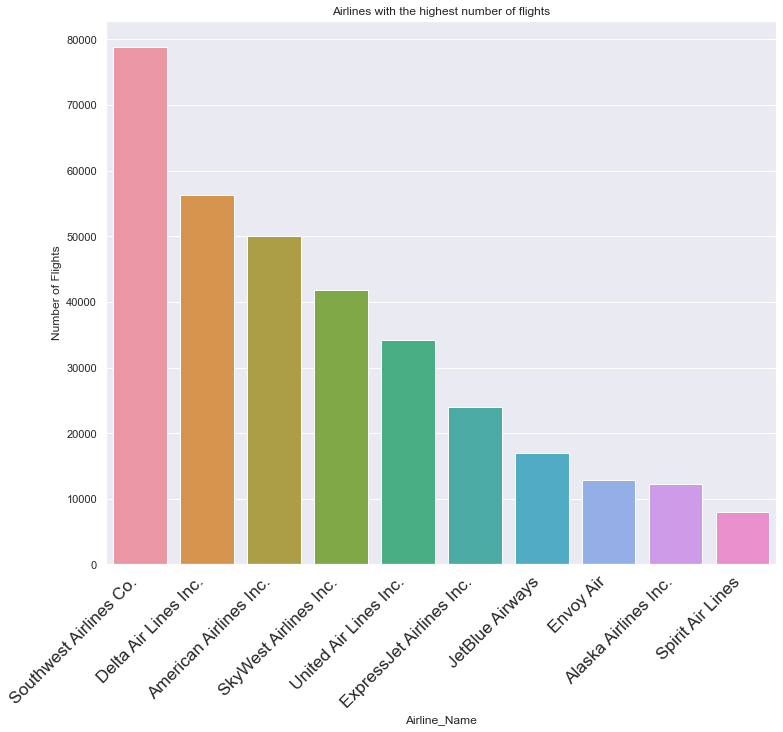

In [ ]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
sns.barplot(data=a1, x=a1.Airline_Name, y=a1.FlightDate)

plt.title('Airlines with the highest number of flights')
plt.xlabel('Airline_Name')
plt.ylabel('Number of Flights')

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

### 10. Airlines with highest freq departure delay? 

The same top 10 airlines appear in all 3 analyses, with varied order. The top 3 are Southwest Airlines, Delta Airlines, and American Airlines.

In [ ]:
airline_depDelay = airline_df[['Airline_Name', 'Departure_Delay']]
airline_depDelay = airline_depDelay.groupby(by='Airline_Name').count()
airline_depDelay = airline_depDelay.sort_values(by=['Departure_Delay'], ascending=False)
a2 = airline_depDelay.head(10).reset_index()
a2

,Airline_Name,Departure_Delay
0,Southwest Airlines Co.,67448
1,Delta Air Lines Inc.,50749
2,American Airlines Inc.,43711
3,SkyWest Airlines Inc.,36348
4,United Air Lines Inc.,29371
5,ExpressJet Airlines Inc.,20190
6,JetBlue Airways,13846
7,Alaska Airlines Inc.,11083
8,Envoy Air,10999
9,Spirit Air Lines,6732


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Southwest Airlines Co.'),
  Text(1, 0, 'Delta Air Lines Inc.'),
  Text(2, 0, 'American Airlines Inc.'),
  Text(3, 0, 'SkyWest Airlines Inc.'),
  Text(4, 0, 'United Air Lines Inc.'),
  Text(5, 0, 'ExpressJet Airlines Inc.'),
  Text(6, 0, 'JetBlue Airways'),
  Text(7, 0, 'Alaska Airlines Inc.'),
  Text(8, 0, 'Envoy Air'),
  Text(9, 0, 'Spirit Air Lines')])

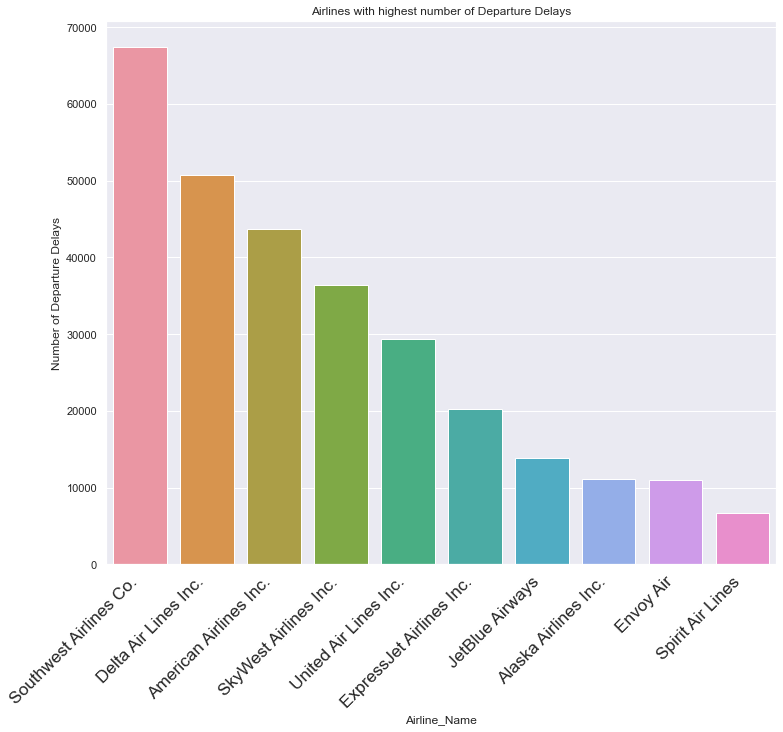

In [ ]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
sns.barplot(data=a2, x=a2.Airline_Name, y=a2.Departure_Delay)

plt.title('Airlines with highest number of Departure Delays')
plt.xlabel('Airline_Name')
plt.ylabel('Number of Departure Delays')


plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

In [ ]:
### percentages 

freq_depDelay = airline_df[['Airline_Name', 'IsDepDelay']]
freq_depDelay = freq_depDelay.groupby(by='Airline_Name')
freq_depDelay.head()
freq_depDelay = freq_depDelay['IsDepDelay'].value_counts(normalize=True).mul(100).astype(str)+'%'
freq_depDelay = freq_depDelay.rename('Percentage_of_Flights_Delayed_on_Departure').reset_index()

freq_depDelay

freq_depDelay = freq_depDelay[freq_depDelay['Airline_Name'].str.contains('Southwest|Delta|American|Skywest|United|Express|Jet|Alaska|Envoy|Spirit', na=False)]

freq_depDelay = freq_depDelay.sort_values(by='Percentage_of_Flights_Delayed_on_Departure')

freq_depDelay

,Airline_Name,IsDepDelay,Percentage_of_Flights_Delayed_on_Departure
3,Alaska Airlines Inc.,True,27.955140798952193%
9,Delta Air Lines Inc.,True,31.525700976121474%
15,ExpressJet Airlines Inc.,True,31.89863905819487%
13,Envoy Air,True,33.14908524717789%
33,Spirit Air Lines,True,34.59936908517351%
7,American Airlines Inc.,True,34.72480086243038%
37,United Air Lines Inc.,True,38.33977059925094%
21,JetBlue Airways,True,40.26332804326104%
31,Southwest Airlines Co.,True,47.942097324156116%
30,Southwest Airlines Co.,False,52.057902675843884%


### 11. Airlines with highest freq arrival delay? 

In [ ]:
airport_arrDelay = airline_df[['Airline_Name', 'Arrival_Delay']]
airport_arrDelay = airport_arrDelay.groupby(by='Airline_Name').count()
airport_arrDelay = airport_arrDelay.sort_values(by=['Arrival_Delay'], ascending=False)
a3 = airport_arrDelay.head(10).reset_index()
a3

,Airline_Name,Arrival_Delay
0,Southwest Airlines Co.,72299
1,Delta Air Lines Inc.,52458
2,American Airlines Inc.,45388
3,SkyWest Airlines Inc.,37665
4,United Air Lines Inc.,30735
5,ExpressJet Airlines Inc.,21115
6,JetBlue Airways,14705
7,Envoy Air,11440
8,Alaska Airlines Inc.,11431
9,Spirit Air Lines,7032


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Southwest Airlines Co.'),
  Text(1, 0, 'Delta Air Lines Inc.'),
  Text(2, 0, 'American Airlines Inc.'),
  Text(3, 0, 'SkyWest Airlines Inc.'),
  Text(4, 0, 'United Air Lines Inc.'),
  Text(5, 0, 'ExpressJet Airlines Inc.'),
  Text(6, 0, 'JetBlue Airways'),
  Text(7, 0, 'Envoy Air'),
  Text(8, 0, 'Alaska Airlines Inc.'),
  Text(9, 0, 'Spirit Air Lines')])

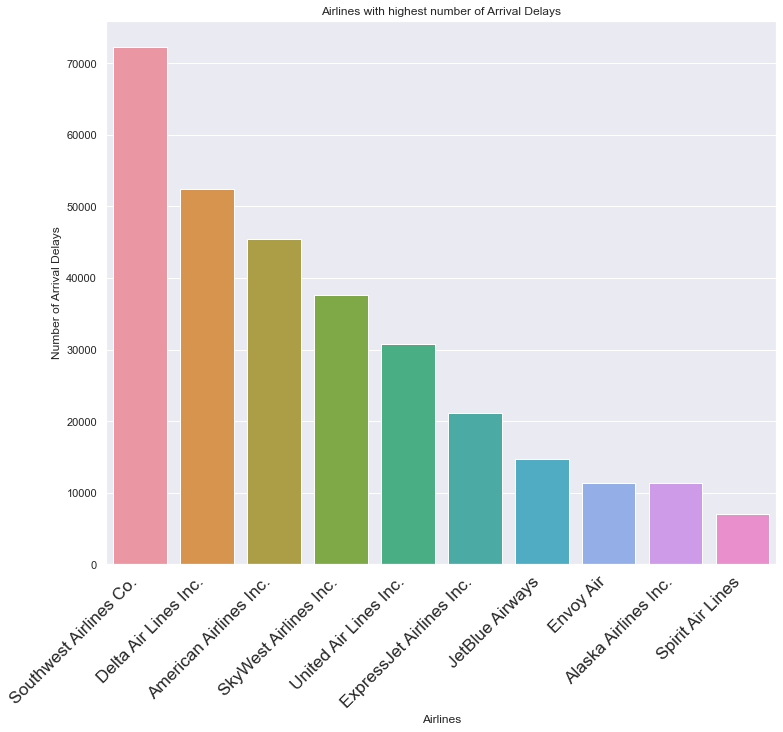

In [ ]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
sns.barplot(data=a3, x=a3.Airline_Name, y=a3.Arrival_Delay)

plt.title('Airlines with highest number of Arrival Delays')
plt.xlabel('Airlines')
plt.ylabel('Number of Arrival Delays')



plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

In [ ]:
### percentages arrival delay

freq_arrDelay = airline_df[['Airline_Name', 'IsArrDelay']]
freq_arrDelay = freq_arrDelay.groupby(by='Airline_Name')
freq_arrDelay.head()
freq_arrDelay = freq_arrDelay['IsArrDelay'].value_counts(normalize=True).mul(100).astype(str)+'%'
freq_arrDelay = freq_arrDelay.rename('Percentage_of_Flights_Delayed_on_Arrival').reset_index()

freq_arrDelay

freq_arrDelay = freq_arrDelay[freq_arrDelay['Airline_Name'].str.contains('Southwest|Delta|American|Skywest|United|Express|Jet|Alaska|Envoy|Spirit', na=False)]
freq_arrDelay = freq_arrDelay.sort_values(by='Percentage_of_Flights_Delayed_on_Arrival')
freq_arrDelay

,Airline_Name,IsArrDelay,Percentage_of_Flights_Delayed_on_Arrival
9,Delta Air Lines Inc.,True,28.757356471027506%
37,United Air Lines Inc.,True,34.22284644194756%
3,Alaska Airlines Inc.,True,35.1833660772757%
33,Spirit Air Lines,True,36.41640378548896%
7,American Airlines Inc.,True,37.455830388692576%
15,ExpressJet Airlines Inc.,True,37.86423979293646%
31,Southwest Airlines Co.,True,39.345425967474114%
21,JetBlue Airways,True,39.71080938106154%
13,Envoy Air,True,40.54495912806539%
12,Envoy Air,False,59.45504087193461%


### 12. Airlines with high mean departure delay in minutes? (Heidi)

In [ ]:
# TODO: Replace 'Origin_Airport' columns with 'Origin_Airport_Name'
airline_df.groupby('Origin_Airport')['DepDelayMinutes'] \
    .mean() \
    .reset_index(name = 'Mean delay (minutes)') \
    .sort_values('Mean delay (minutes)', ascending = False).head()

,Origin_Airport,Mean delay (minutes)
250,OGD,13.0
19,ART,9.0
262,OWB,4.5
40,BKG,4.0
174,ILG,4.0


### 13. Airlines with high mean arrival delay in minutes? (Heidi)

In [ ]:
airline_df.groupby('Airline_Name')['ArrDelayMinutes'] \
    .mean() \
    .reset_index(name = 'Mean delay (minutes)') \
    .sort_values('Mean delay (minutes)', ascending = False).head()

,Airline_Name,Mean delay (minutes)
8,Frontier Airlines Inc.,2.382324
2,Allegiant Air,2.354545
15,Southwest Airlines Co.,2.344741
19,Virgin America,2.316434
6,Envoy Air,2.293052


### 14. Origin with highest freq departure delay? 

The origin that has the highest delayed departure is Las Vegas with 43.9%, then Los Angeles, CA with 40.9&, and Chicago, IL (O'Hare) at 39.5%.


In [ ]:
or_DepDelay = airline_df[['Origin_Airport', 'Departure_Delay']]
or_DepDelay = or_DepDelay.groupby(by='Origin_Airport').count()
or_DepDelay = or_DepDelay.sort_values(by=['Departure_Delay'], ascending=False)
o2 = or_DepDelay.head(10).reset_index()
o2

,Origin_Airport,Departure_Delay
0,ATL,20534
1,ORD,14656
2,DFW,12832
3,DEN,11784
4,LAX,11282
5,PHX,8841
6,SFO,8649
7,IAH,8356
8,CLT,8169
9,LAS,8054


In [ ]:
### percentages origin departure

o1_freq_dep = airline_df[['Origin_Airport', 'IsDepDelay']]
o1_freq_dep = o1_freq_dep.groupby(by='Origin_Airport')
o1_freq_dep.head()
o1_freq_dep = o1_freq_dep['IsDepDelay'].value_counts(normalize=True).mul(100).astype(str)+'%'
o1_freq_dep = o1_freq_dep.rename('Percentage_of_Flights_Delayed_on_Departure').reset_index()
o1_freq_dep


o1_freq_dep = o1_freq_dep[o1_freq_dep['Origin_Airport'].str.contains('LAX|ATL|ORD|DFW|DEEN|PHX|SFO|IAH|CLT|LAS', na=False)]
o1_freq_dep = o1_freq_dep.sort_values(by='Percentage_of_Flights_Delayed_on_Departure', ascending=False)
o1_freq_dep


,Origin_Airport,IsDepDelay,Percentage_of_Flights_Delayed_on_Departure
335,IAH,False,65.02371623015054%
40,ATL,False,63.527595522964106%
148,CLT,False,63.40244550770866%
537,PHX,False,61.6577221228384%
190,DFW,False,61.583908656399366%
630,SFO,False,60.989064163360105%
507,ORD,False,60.512878701917614%
387,LAX,False,59.05871601553575%
383,LAS,False,56.10486891385767%
384,LAS,True,43.89513108614232%


### 15. Origins with highest freq arrival delay? 

Chicago, IL has the highest departure delay rate of 41.7%, followed by Dallas-Fort Worth, Texas (41.7%) and Charlotte, North Carolina (40.3%).

In [ ]:
or_ArrDelay = airline_df[['Origin_Airport', 'Arrival_Delay']]
or_ArrDelay = or_ArrDelay.groupby(by='Origin_Airport').count()
or_ArrDelay = or_ArrDelay.sort_values(by=['Arrival_Delay'], ascending=False)
o3 = or_ArrDelay.head(10).reset_index()
o3

,Origin_Airport,Arrival_Delay
0,ATL,21540
1,ORD,15448
2,DFW,13504
3,DEN,12485
4,LAX,11964
5,PHX,9322
6,SFO,9179
7,IAH,8760
8,LAS,8553
9,CLT,8490


In [ ]:
### percentages - origin arrival delay

a1_freq_arr = airline_df[['Origin_Airport', 'IsArrDelay']]
a1_freq_arr = a1_freq_arr.groupby(by='Origin_Airport')
a1_freq_arr.head()
a1_freq_arr = a1_freq_arr['IsArrDelay'].value_counts(normalize=True).mul(100).astype(str)+'%'
a1_freq_arr = a1_freq_arr.rename('Percentage_of_Flights_Delayed_on_Arrival').reset_index()
a1_freq_arr


a1_freq_arr = a1_freq_arr[a1_freq_arr['Origin_Airport'].str.contains('LAX|ATL|ORD|DFW|DEEN|PHX|SFO|IAH|CLT|LAS', na=False)]
a1_freq_arr = a1_freq_arr.sort_values(by='Percentage_of_Flights_Delayed_on_Arrival', ascending=False)
a1_freq_arr

,Origin_Airport,IsArrDelay,Percentage_of_Flights_Delayed_on_Arrival
40,ATL,False,67.54148977228868%
335,IAH,False,64.013198597649%
537,PHX,False,62.214271516597094%
383,LAS,False,61.64794007490637%
387,LAX,False,61.54139060239129%
631,SFO,False,59.982580083228484%
150,CLT,False,59.70228601807549%
192,DFW,False,58.31120552310144%
507,ORD,False,58.243503914671514%
508,ORD,True,41.75649608532849%


### 16. Destinations with highest freq arrival delay? 


The San Fransico airport (SFO) has the highest departure delay rate of 41.93%, followed by Los Angeles, CA (40.25%) and Phoenix, Arizona (37.72%).

In [ ]:
dest_ArrDelay = airline_df[['Dest_Airport', 'Arrival_Delay']]
dest_ArrDelay = dest_ArrDelay.groupby(by='Dest_Airport').count()
dest_ArrDelay = dest_ArrDelay.sort_values(by=['Arrival_Delay'], ascending=False)
d1 = dest_ArrDelay.head(10).reset_index()
d1

,Dest_Airport,Arrival_Delay
0,ATL,21476
1,ORD,15966
2,DFW,13673
3,DEN,12672
4,LAX,12110
5,PHX,9355
6,SFO,9022
7,IAH,8826
8,LAS,8652
9,CLT,8636


In [ ]:
### percentages - destination arrival delay

dest2_freq_arr = airline_df[['Dest_Airport', 'IsArrDelay']]
dest2_freq_arr = dest2_freq_arr.groupby(by='Dest_Airport')
dest2_freq_arr.head()
dest2_freq_arr = dest2_freq_arr['IsArrDelay'].value_counts(normalize=True).mul(100).astype(str)+'%'
dest2_freq_arr = dest2_freq_arr.rename('Percentage_of_Flights_Delayed_on_Arrival').reset_index()
dest2_freq_arr


dest2_freq_arr = dest2_freq_arr[dest2_freq_arr['Dest_Airport'].str.contains('LAX|ATL|ORD|DFW|DEEN|PHX|SFO|IAH|CLT|LAS', na=False)]
dest2_freq_arr = dest2_freq_arr.sort_values(by='Percentage_of_Flights_Delayed_on_Arrival', ascending=False)

dest2_freq_arr

,Dest_Airport,IsArrDelay,Percentage_of_Flights_Delayed_on_Arrival
42,ATL,False,69.88071142500323%
150,CLT,False,66.74553667455366%
332,IAH,False,65.6866819031789%
192,DFW,False,63.66930171277997%
505,ORD,False,63.244775455758116%
380,LAS,False,62.91825497670479%
534,PHX,False,62.264150943396224%
384,LAX,False,59.75327102803738%
627,SFO,False,58.06757782839787%
628,SFO,True,41.93242217160213%


### 17. Destinations with highest freq departure delay? 

The San Fransico airport (SFO) has the highest departure delay rate of 42.4%, followed by Las Vegas (40.3%) and Los Angeles, CA (38.8%).

In [ ]:
dest_DepDelay = airline_df[['Dest_Airport', 'Departure_Delay']]
dest_DepDelay = dest_DepDelay.groupby(by='Dest_Airport').count()
dest_DepDelay = dest_DepDelay.sort_values(by=['Departure_Delay'], ascending=False)
d2 = dest_DepDelay.head(10).reset_index()
d2

,Dest_Airport,Departure_Delay
0,ATL,20810
1,ORD,15417
2,DFW,13234
3,DEN,12122
4,LAX,11669
5,PHX,8904
6,IAH,8581
7,SFO,8528
8,CLT,8356
9,LAS,8195


In [ ]:
### percentages - destination departure delay

dest2_freq_dep = airline_df[['Dest_Airport', 'IsDepDelay']]
dest2_freq_dep = dest2_freq_dep.groupby(by='Dest_Airport')
dest2_freq_dep.head()
dest2_freq_dep = dest2_freq_dep['IsDepDelay'].value_counts(normalize=True).mul(100).astype(str)+'%'
dest2_freq_dep = dest2_freq_dep.rename('Percentage_of_Flights_Delayed_on_Departure').reset_index()
dest2_freq_dep


dest2_freq_dep = dest2_freq_dep[dest2_freq_dep['Dest_Airport'].str.contains('LAX|ATL|ORD|DFW|DEEN|PHX|SFO|IAH|CLT|LAS', na=False)]
dest2_freq_dep = dest2_freq_dep.sort_values(by='Percentage_of_Flights_Delayed_on_Departure', ascending=False)

dest2_freq_dep

,Dest_Airport,IsDepDelay,Percentage_of_Flights_Delayed_on_Departure
332,IAH,False,70.36152088094744%
150,CLT,False,69.6493869649387%
41,ATL,False,68.38637440248051%
192,DFW,False,67.04874835309617%
504,ORD,False,66.3683859493108%
533,PHX,False,62.31354341598341%
383,LAX,False,61.21121495327103%
379,LAS,False,59.720457433290974%
626,SFO,False,57.62148823082763%
627,SFO,True,42.37851176917236%


### 18. Busiest months of the year?

In [ ]:
monthFreqDf = pd.value_counts(airline_df['Month']) \
    .rename_axis('Month').reset_index(name='Number of flights') \
    .sort_values(by = ['Month'])
monthFreqDf

,Month,Number of flights
10,1,29967
11,2,27739
4,3,32476
6,4,31639
3,5,32484
5,6,32391
0,7,33867
1,8,33269
9,9,30788
2,10,32559


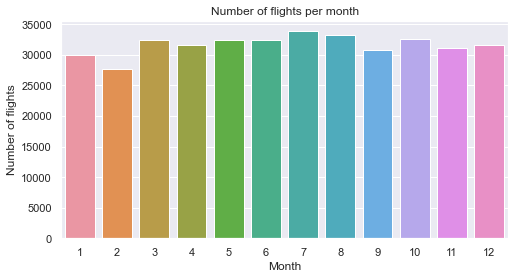

In [ ]:
display_bar_char('Month', 'Number of flights', monthFreqDf, 'v', (8, 4), "Number of flights per month")

&rightarrow; July is the busiest month of the year. This is reasonable since a lot of people go on vacation during the summer. It's interesting to see that February has significantly less flights than other months.

### 19. Relationship between Month and Departure Delay

In [ ]:
depDelayFreqByMonth = airline_df.groupby('Month')['IsDepDelay'].sum().reset_index(name = 'Total Flights')
depDelayFreqByMonth

,Month,Total Flights
0,1,11112
1,2,10303
2,3,11766
3,4,10736
4,5,11937
5,6,13559
6,7,13507
7,8,12463
8,9,8907
9,10,10450


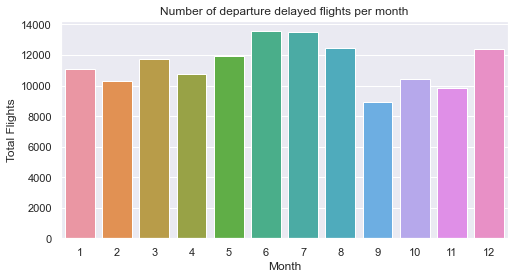

In [ ]:
display_bar_char('Month', 'Total Flights', depDelayFreqByMonth, 'v', (8, 4), "Number of departure delayed flights per month")

&rightarrow; Since the height of columns are different, there's a relationship between month whether a flight delay departure. We can see that September and February have the least number of flights delayed departure while March, July and December have the most number of flights delayed departure.

### 20. Relationship between Month and Arrival Delay 

In [ ]:
arrDelayFreqByMonth = airline_df.groupby('Month')['IsArrDelay'].sum().reset_index(name = 'Total Flights')
arrDelayFreqByMonth

,Month,Total Flights
0,1,11157
1,2,10432
2,3,11928
3,4,10963
4,5,11716
5,6,13517
6,7,13200
7,8,12610
8,9,9261
9,10,10725


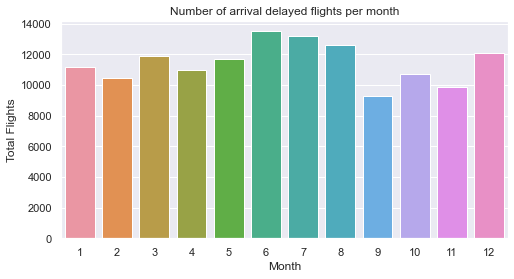

In [ ]:
display_bar_char('Month', 'Total Flights', arrDelayFreqByMonth, 'v', (8, 4), "Number of arrival delayed flights per month")

&rightarrow; This graph looks verry similar to the "Number of departure delayed flights per month" which suggests that there's a strong relationship between departure delay and arrival delay.

### 21. Relationship between hour and median departure delay in minutes? (Khanh)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = "/content/drive/MyDrive/INFO 442/Data Sources/airlines_updated.csv"
airline_df = import_data(path)

In [ ]:
airline_df["Scheduled_Departure_Hour"] = airline_df["Scheduled_Departure"]//100
airline_df["Scheduled_Departure_Hour"]

0         19
1          9
2         19
3         15
4          6
          ..
379960    15
379961     7
379962    13
379963    10
379964    10
Name: Scheduled_Departure_Hour, Length: 379965, dtype: int64

In [ ]:
airline_df_depdelay_by_hour = airline_df.groupby(["Scheduled_Departure_Hour"])[["DepDelayMinutes"]].median().reset_index()
airline_df_depdelay_by_hour

,Scheduled_Departure_Hour,DepDelayMinutes
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


### 22. Relationship between hour and median arrival delay in minutes? (Khanh)


In [ ]:
airline_df["Scheduled_Arrival_Hour"] = airline_df["Scheduled_Arrival"]//100
airline_df["Scheduled_Arrival_Hour"]

0         20
1         11
2         21
3         16
4          7
          ..
379960    17
379961     8
379962    15
379963    11
379964    12
Name: Scheduled_Arrival_Hour, Length: 379965, dtype: int64

In [ ]:
airline_df_arrdelay_by_hour = airline_df.groupby(["Scheduled_Arrival_Hour"])[["ArrDelayMinutes"]].median().reset_index()
airline_df_arrdelay_by_hour

,Scheduled_Arrival_Hour,ArrDelayMinutes
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


### 23. Relationship between day of the week and median arrival delay in minutes? (Khanh)




In [ ]:
airline_df_arrdelay_by_day = airline_df.groupby(["Day"])[["ArrDelayMinutes"]].median().reset_index()
airline_df_arrdelay_by_day

,Day,ArrDelayMinutes
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,0.0


 ### 24. Difference between arrival delay (minutes) and departure delay (minutes) for every flight? (Histogram to see the difference distribution) (Khanh)

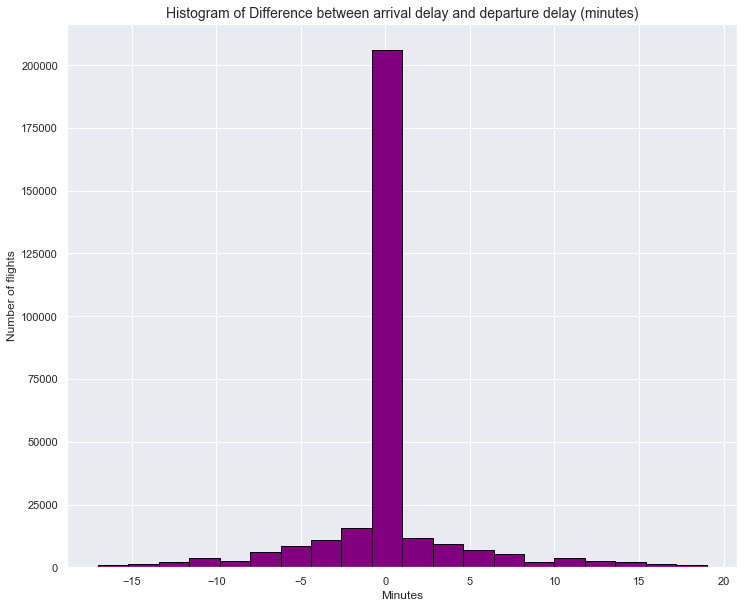

In [ ]:
airline_df["ArrDeDelayDifferenceMinutes"] = airline_df["ArrDelayMinutes"] - airline_df["DepDelayMinutes"]

# Plotting
plt.hist(airline_df["ArrDeDelayDifferenceMinutes"].values, color='purple', edgecolor='black', bins=20)
plt.title('Histogram of Difference between arrival delay and departure delay (minutes)', size=14)
plt.xlabel('Minutes', size=12)
plt.ylabel('Number of flights', size=12)
# plt.rcParams["font.size"] = 12
plt.show()

### 25. Relationship between taxi in/taxi out and departure/arrival delay?

Taxi In and Departure Delay

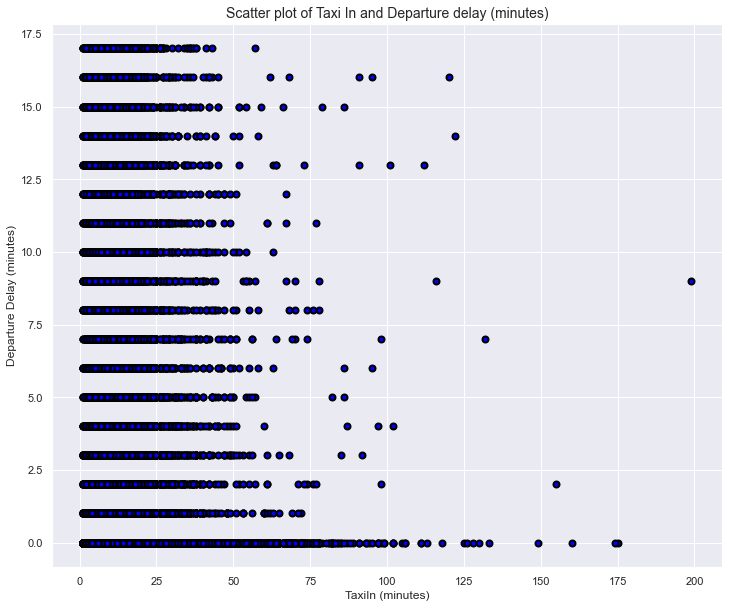

In [ ]:
plt.scatter(x=airline_df.TaxiIn, y=airline_df.DepDelayMinutes, c='blue', linewidths = 2, edgecolor='black')
plt.title('Scatter plot of Taxi In and Departure delay (minutes)', size=14)
plt.xlabel('TaxiIn (minutes)', size=12)
plt.ylabel('Departure Delay (minutes)', size=12)
plt.show()

Taxi Out and Arrival Delay

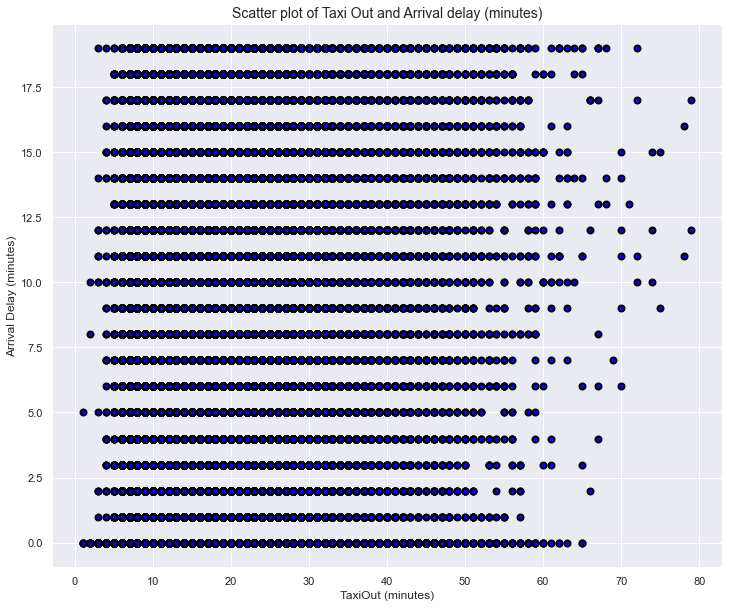

In [ ]:
plt.scatter(x=airline_df.TaxiOut, y=airline_df.ArrDelayMinutes, c='blue', linewidths = 2, edgecolor='black')
plt.title('Scatter plot of Taxi Out and Arrival delay (minutes)', size=14)
plt.xlabel('TaxiOut (minutes)', size=12)
plt.ylabel('Arrival Delay (minutes)', size=12)
plt.show()